# Bayer NLP task - BERT Model Evaluation

In this notebook, we will perform sentiment classification using Transfer Learning and BERT.
BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.
Note that due to a lack of memory notebook was in a GCP instance, and as such is self-encapsulated.

Notebook follows prior model evaluation notebooks.
(c) Yijie Xu

### Install, import libraries, initialize variables

In [1]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install torchsampler

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,balanced_accuracy_score, f1_score
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set BERT max sentence length.
MAX_LEN = 160
class_names = ['negative', 'neutral', 'positive']
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Data

In [5]:
df = pd.read_csv('../nlptask/sentences_with_sentiment.csv', sep =",")
df.shape

(266, 5)

In [6]:
# Data inspections
df.head()

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0


In [7]:
# NaN check
df.isnull().sum()

ID          0
Sentence    0
Positive    0
Negative    0
Neutral     0
dtype: int64

In [8]:
# Function to convert score to sentiment, note the change in definition for Torch
def convert_sentiment(row):
    if row['Positive'] == 1:
        val = 2
    elif row['Negative'] ==1:
        val=0
        
    else:
        val=1 #neutral is 1 here because of torch limitations
    return val

# Apply to the dataset 
df["sentiment"]=df.apply(lambda row: convert_sentiment(row), axis=1)

## Data Preprocessing

Cleaning and BERT-specific tokenization of input sentences.

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask


In [9]:
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

def clean(sentence): 
    # changing to lower case
    lower = sentence.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe
# Data cleaning
def processing(data):
    data['clean'] =clean(data['Sentence'])
    stop_words = set(stopwords.words('english'))
    data['clean'] = data['clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    # Can also stem words
    Snow_ball = SnowballStemmer("english")
    data['clean_stem'] = data['clean'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))

    return data

df = processing(df)

df.head()

,ID,Sentence,Positive,Negative,Neutral,sentiment,clean,clean_stem
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,results 2nd line treatment show orr 33 patient...,result 2nd line treatment show orr 33 patient ...
1,2,The long duration of response and high durable...,1,0,0,2,long duration response high durable response r...,long durat respons high durabl respons rate ob...
2,3,The median OS time in the updated results exce...,0,0,1,1,median os time updated results exceeded 1 year,median os time updat result exceed 1 year
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0,2,therefore clinical benefit 2nd line treatment ...,therefor clinic benefit 2nd line treatment con...
4,5,"The data provided in 1st line, although prelim...",1,0,0,2,data provided 1st line although preliminary sh...,data provid 1st line although preliminari show...


In [10]:
# Set the model name
MODEL_NAME = 'bert-large-uncased'

# Build a BERT based tokenizer 
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

### Dataset Preparation

Define Pytorch-specific Dataset class, and allow for on-demand encoding  using BertTokenizer.
Following this, perform train-test data split and build dataloaders.

In [11]:
class BayerReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    def get_labels(self):
        return self.targets
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [12]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, RandomOverSampler
# Data split 80% train data and 20% validation data.
# You can alternatively also split it 8-1-1, make sure to modify metrics accordingly.
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42,stratify=df["sentiment"])



In [13]:

from torchsampler import ImbalancedDatasetSampler
#Create a dataloader to release data in batches.

def create_train_data_loader(df, tokenizer, max_len, batch_size):
    ds = BayerReviewDataset(
        reviews=df.Sentence.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        sampler=ImbalancedDatasetSampler(ds),
        batch_size=batch_size,
        num_workers=0
    )


def create_test_data_loader(df, tokenizer, max_len, batch_size):
    ds = BayerReviewDataset(
        reviews=df.Sentence.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [14]:
# Create train, andval data loaders
BATCH_SIZE = 16
train_data_loader = create_train_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_test_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)


In [15]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Transfer Learning with BERT for Sentiment Classification

We’ll use the basic BertModel and build our sentiment classifier on top of it for our 3 classes.
We use a dropout layer for some regularization and a fully-connected layer for our output. 



In [16]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [17]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [18]:
# Instantiate the model and move to classifier
model = SentimentClassifier(3)
model = model.to(device)

#### Model Characterstics

In [19]:
# Number of hidden units
print(bert_model.config.hidden_size)

1024


### Model Training

Using the AdamW optimizer provided by Hugging Face, which corrects weight decay. 
Also using a linear scheduler with no warmup.

In [20]:
# Number of iterations 
EPOCHS = 40

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [21]:
#  Single epoch training script
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
%%time

#Main training script
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/40
----------
Train loss 1.1425183159964425 accuracy 0.4811320754716981
Val   loss 0.8327692449092865 accuracy 0.6296296296296295

Epoch 2/40
----------
Train loss 0.7609054020472935 accuracy 0.6745283018867925
Val   loss 0.7456496953964233 accuracy 0.7037037037037037

Epoch 3/40
----------
Train loss 0.6118882724217006 accuracy 0.7830188679245282
Val   loss 0.7238110154867172 accuracy 0.7592592592592592

Epoch 4/40
----------
Train loss 0.4484501417194094 accuracy 0.8632075471698113
Val   loss 0.725923702120781 accuracy 0.7777777777777777

Epoch 5/40
----------
Train loss 0.46848291371549877 accuracy 0.8679245283018867
Val   loss 0.7186416238546371 accuracy 0.6851851851851851

Epoch 6/40
----------
Train loss 0.4036400594881603 accuracy 0.9009433962264151
Val   loss 0.6653918474912643 accuracy 0.7407407407407407

Epoch 7/40
----------
Train loss 0.27976205732141224 accuracy 0.9669811320754716
Val   loss 0.7145658880472183 accuracy 0.7777777777777777

Epoch 8/40
----------
Trai

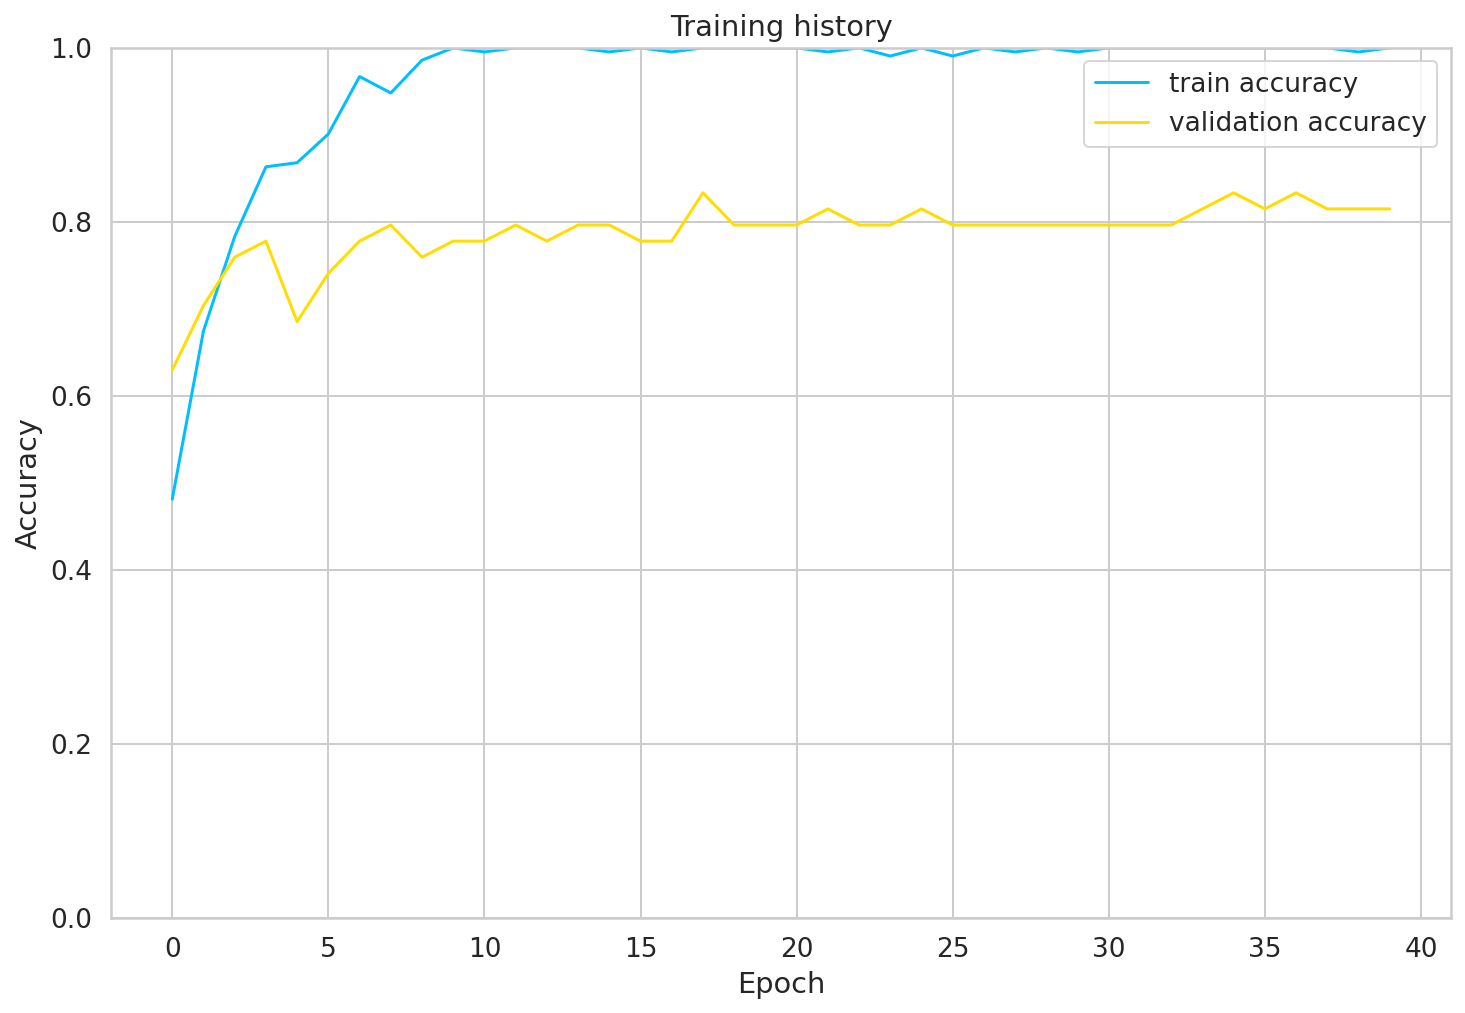

In [24]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities. We also use the same standard utility functions previously used for our other models

In [25]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [26]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    val_data_loader
)

In [27]:
accuracy =accuracy_score(y_test, y_pred)
print(accuracy)

0.8148148148148148


In [28]:
accuracy_b =balanced_accuracy_score(y_test, y_pred)
print(accuracy_b)

0.7041847041847041


In [29]:
f1 =f1_score(y_test, y_pred,average="weighted")
print(f1)

0.8046940713607379


In [30]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.80      0.57      0.67         7
     neutral       0.67      0.57      0.62        14
    positive       0.86      0.97      0.91        33

    accuracy                           0.81        54
   macro avg       0.78      0.70      0.73        54
weighted avg       0.81      0.81      0.80        54



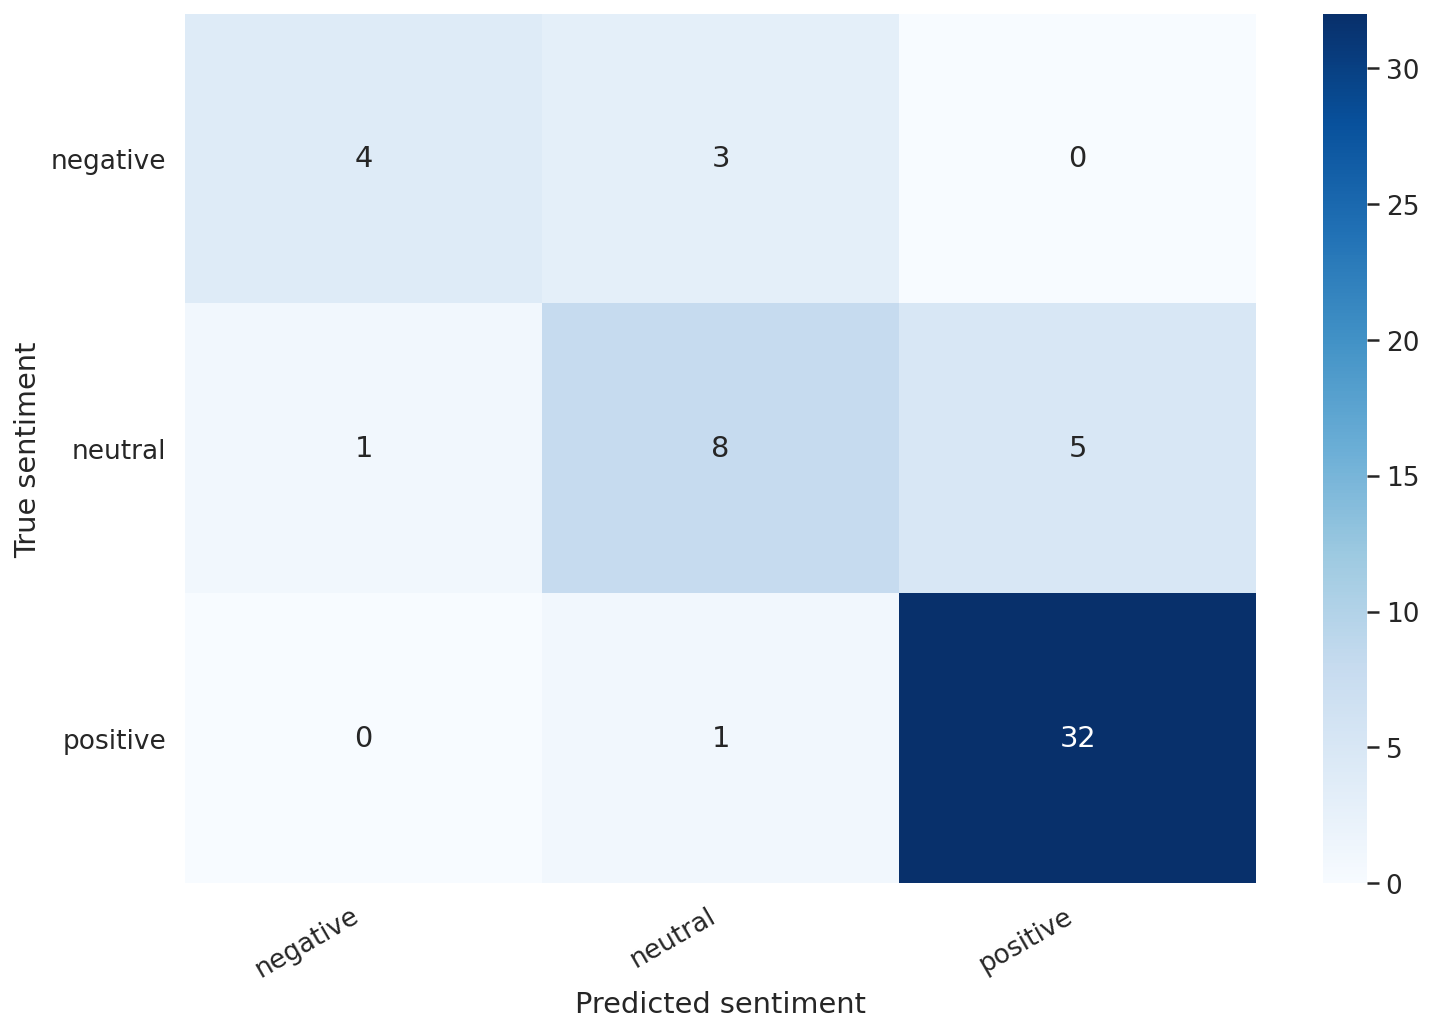

In [31]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Predicting on raw text

In [32]:
review_text = "No major concerns were identified in the study"

In [33]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [34]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: No major concerns were identified in the study
Sentiment  : positive
